# Exercise 01
**Kernel Methods in Machine Learning (CS-E4830)**

**Submission deadline:** 30.3.2021 at 4pm

**Tutorial session:** 18.3.2021 at 4:15pm - 6pm

<div class="alert alert-success">
    <b>Tasks:</b>
   
1. [Implement kernel matrix calculation](#task_1) 
 1. [Linear kernel](#task_1_a) (**2 Point**)
 2. [Gaussian kernel](#task_1_b) (**2 Point**)
2. [Implement the Parzen Window Classifier](#task_2) (**3 Point**)
3. [Application of the Parzen Window Classifier](#task_3)
 1. [Implement the hyper parameter optimization](#task_3_a) (**3 Point**)
 2. [Plot validation score for different hyper parameters](#task_3_b)(**0 Point**)
</div> 

<div class="alert alert-info">
    <b>Optional Tasks:</b>
    
4. [Model visualization: Non-linear vs. Linear](#task_4) (**no points**)
</div>

**Version**: 1.2

**Version history**:
- 1.0: Initial version
- 1.1: Fix typo: Parzen Window Clf. dual-variables (alpha) had wrong sign in formula. [Issue on MyCourses](https://mycourses.aalto.fi/mod/forum/discuss.php?d=128291)
- 1.2: Fix typo: Gaussian kernel doc-string, put brackets around the denominator within exponential function.

<div class="alert alert-danger">
    Please add your student number and email address to the notebook into the corresponding cell.
</div>    

#### EMAIL:arttu.hakkinen@aalto.fi

#### STUDENT_NUMBER: 596077

## Import required python packages
All tasks in this exercise can be solved by using only function and packages imported below. Please **do not** use any other imports. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.set_cmap("RdBu_r")

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import KFold, ParameterGrid, BaseCrossValidator, train_test_split
from sklearn.base import clone

<Figure size 432x288 with 0 Axes>

## 1. Kernel matrix calculation <a id='task_1'></a>
Your task is to **implement two functions to calculate Linear- and Gaussian-kernel matrices** for two sets of feature vectors $\mathbf{X}_A\in\mathbb{R}^{n_A\times d}, \mathbf{X}_B\in\mathbb{R}^{n_B\times d}$, where $d$ is the dimension of the feature vectors, and $n_a$ and $n_B$ are the number of examples in set $A$ respectively $B$.

### A. Linear kernel (2 Point) <a id='task_1_a'></a>
<div class="alert alert-success">
    <b>Task:</b>
    Implement missing code parts of the function calculation the linear kernel matrix given two feature vector matrices $\mathbf{X}_A$ and $\mathbf{X}_B$. The resulting kernel matrix $\mathbf{K}_{lin}$ must have dimension $n_A\times n_B$. For a single entry in the kernel matrix it must hold:
    <br/><br/>
    $$[\mathbf{K}_{lin}]_{ij}=\kappa_{lin}(\mathbf{x}_i,\mathbf{x}_j)=\langle\mathbf{x}_i,\mathbf{x}_j\rangle,$$
    <br/>
    with $\mathbf{x}_i,\mathbf{x}_j\in\mathbb{R}^{d}$ being two examples from set $A$ respecively $B$.
</div>

In [4]:
def linear_kernel(X_A, X_B=None):
    """
    Calculate linear kernel matrix between two sets of feature-vectors, so that:

        k_ij = <x_i, x_j>

    :param X_A: array-like, shape=(n_samples_A, d), feature-matrix of set A
    :param X_B: array-like, shape=(n_samples_B, d), feature-matrix of set B or None, than Y = X

    :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
    """
    if X_B is None:
        X_B = X_A

    # YOUR CODE HERE
    K_AB = np.inner(X_A, X_B)

    return K_AB

In [6]:
X_A = np.array([[1], [2], [3], [4]])
X_B = np.array([[0], [2], [1]])

# Test size
np.testing.assert_equal(linear_kernel(X_A, X_B).shape, (4, 3))
np.testing.assert_equal(linear_kernel(X_A).shape, (4, 4))

# Test values
np.testing.assert_equal(linear_kernel(X_A)[0, 0], 1)
np.testing.assert_equal(linear_kernel(X_A)[1, 1], 4)
np.testing.assert_equal(linear_kernel(X_A)[0, 2], 3)
np.testing.assert_equal(linear_kernel(X_A)[2, 0], 3)

np.testing.assert_equal(linear_kernel(X_A, X_B)[0, 0], 0)
np.testing.assert_equal(linear_kernel(X_A, X_B)[0, 1], 2)

# Test performance
import time
time_tolerance = 1  # in seconds
size = 3000

t0 = time.time()
a = linear_kernel(np.random.rand(size), np.random.rand(size))
t1 = time.time()
total = t1 - t0
print('Time to run with size {} = {:.4f} seconds'.format(size, total))
assert total < time_tolerance, 'Time limit exceeded'


Time to run with size 3000 = 0.0009 seconds


### B. Gaussian kernel (2 Point) <a id='task_1_b'></a>
<div class="alert alert-success">
    <b>Task:</b>
    Implement missing code parts of the function calculation the Gaussian kernel matrix given two feature vector matrices $\mathbf{X}_A$ and $\mathbf{X}_B$. The resulting kernel matrix $\mathbf{K}_{gau}$ must have dimension $n_A\times n_B$. For a single entry in the kernel matrix it must hold:
    <br/><br/>
    $$[\mathbf{K}_{gau}]_{ij}=\kappa_{gau}(\mathbf{x}_i,\mathbf{x}_j)=\exp\left(-\frac{\|\mathbf{x}_i-\mathbf{x}_j\|^2}{2\sigma^2}\right)$$
    <br/>
    with $\mathbf{x}_i,\mathbf{x}_j\in\mathbb{R}^{d}$ being two examples from set $A$ respecively $B$, and $\gamma>0$ being the bandwidth parameter.
</div>

In [129]:
def gaussian_kernel(X_A, X_B=None, sigma=None):
    """
    Calculate the Gaussian kernel matrix, so that

        k_ij = exp(-||x_i - x_j||^2 / (2 * sigma^2))

    :param X_A: array-like, shape=(n_samples_A, n_features), feature-matrix of set A
    :param X_B: array-like, shape=(n_samples_B, n_features), feature-matrix of set B or None, than X_B = X_A
    :param sigma: scalar, bandwidth parameter

    :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
    """
    if X_B is None:
        X_B = X_A

    n_A = X_A.shape[0]
    n_B = X_B.shape[0]

    if sigma is None:
        sigma = np.sqrt(X_A.shape[1] / 2.0)
    

    # YOUR CODE HERE
    numerator = np.sum(X_A**2, axis=1).reshape(-1,1) + np.sum(X_B**2, axis=1) - 2 * X_A @ X_B.T
    K_AB = np.exp( - numerator / (2*pow(sigma, 2)) )

    return K_AB

In [130]:
X_A = np.array([[1], [2], [3], [4]])
X_B = np.array([[0], [2], [1]])

# Test size
np.testing.assert_equal(gaussian_kernel(X_A, X_B).shape, (4, 3))
np.testing.assert_equal(gaussian_kernel(X_A).shape, (4, 4))

# Test values
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[0, 0], 1)
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[1, 1], 1)
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[0, 2], np.exp(-2))
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[2, 0], np.exp(-2))

np.testing.assert_equal(gaussian_kernel(X_A, X_B, sigma=1)[0, 0], np.exp(-0.5))
np.testing.assert_equal(gaussian_kernel(X_A, X_B, sigma=1)[0, 1], np.exp(-0.5))

# Test performance
import time
time_tolerance = 1  # in seconds
size = 3000
features = 10

t0 = time.time()
a = gaussian_kernel(np.random.rand(size, features), np.random.rand(size, features))
t1 = time.time()
total = t1 - t0
print('Time to run with size {} = {:.4f} seconds'.format(size, total))
assert total < time_tolerance, 'Time limit exceeded'


Time to run with size 3000 = 0.3135 seconds


## 2. Parzen Window Classifier implementation (3 Points) <a id='task_2'></a>
The Parzen Window Classifier prediction model can be written as:


$$
    h(\mathbf{x})=\text{sign}(g(\mathbf{x}))=\text{sign}\left(\sum_{i=1}^{n}\alpha_i\kappa(\mathbf{x}_i,\mathbf{x})+b\right),
$$


with:
- $g:\mathbb{R}^{d}\rightarrow\mathbb{R}$ being the **decision function**
- $b\in\mathbb{R}$ being the **bias term** defined as:


$$
b=\frac{1}{2n_{{-}}^2}\sum_{i,j\in I^{-}}\kappa(\mathbf{x}_i,\mathbf{x}_j)-\frac{1}{2n_{{+}}^2}\sum_{i,j\in I^{+}}\kappa(\mathbf{x}_i,\mathbf{x}_j),
$$


- $\alpha_i$'s $\in\mathbb{R}$ being the **dual variables** for all training examples $\mathbf{x}_i$ defined as:


$$
\alpha_i=\begin{cases}
            \frac{1}{n_{{+}}} & \text{if } y_i=+1\\
            -\frac{1}{n_{{-}}} & \text{if } y_i=-1
         \end{cases}.
$$


We denote the number of positive / negative training examples as $n_{+}$ / $n_{-}$, and $n=n_{+}+n_{-}$, and $I^{+}$ / $I^{-}$ are the indices of the positive / negative training examples. 

Below you find the class-template for the Parzen Window Classifier. It's functionality is split into three parts:

### 1. Intialization of Classifier Object using **__init__()**
A Parzen Window Classifier instance can be created using its constructor and the kernel to be used can be specified, e.g.:
```python
est = ParzenWindowClassifier(kernel="gaussian").
```

### 2. Model Training using **fit()** 
This function takes as input the features of the training examples $\mathbf{X}_{train}$ and their corresponding labels $\mathbf{y}_{train}\in\{-1,1\}^{n_{train}}$ and estimates the $\alpha_i$'s and $b$. The necessary kernel values between the training examples, i.e. $\kappa(\mathbf{x}_i, \mathbf{x}_j)$ are calculated during the fitting process.
```python
est.fit(X_train, y_train)
```

### 3. Prediction for new Examples using **predict()** and **decision_function()**
When the model parameters, i.e. $b$ and $\alpha_i$s, are fitted, than we can make predictions for a new example $\mathbf{x}$ using the function $h(\mathbf{x})$.
```python
y_test_pred = est.predict(X_test)
```
<div class="alert alert-success">
    <b>Task:</b> Implement the missing code parts of <code>fit()</code>, <code>decision_function()</code> and <code>predict()</code>. Make use of the provided formulas (see above).
</div>

<div class="alert alert-warning">
    <b>Hint:</b> The NumPy function <code>np.sum</code> can be used to sum over the elements of a matrix.
</div>

In [207]:
class ParzenWindowClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="gaussian", sigma=None):
        """
        Parzen Window Classifier

        :param kernel: string, specifying which kernel to use. Can be 'gaussian' or 'linear'.
        :param sigma: scalar, gaussian kernel parameter, can be None if the linear kernel is used.
        """
        # Parzen Window Classifier model parameter
        self.b = None  # bias term
        self.alphas = None  # dual variables
        
        # Training data needed for the prediction phase
        self.X_train = None

        # Set up kernel function
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, X_train, y_train):
        """
        Fit a Parzen Window Classifier using training data

        :param X_train: array-like, shape=(n_samples, n_features), feature-matrix
        :param y_train: array-like, shape=(n_samples,) or (n_samples, 1), label vector
        """
        # Calculate the specified kernel
        self.X_train = X_train
        KX_train = self._get_kernel(self.X_train)

        # Get indices of positive and negative examples: I_n, I_p
        # YOUR CODE HERE
        I_n = np.where(y_train < 0)[0]
        I_p = np.where(y_train > 0)[0]

        # Count the number of postitive and negative examples: n_n, n_p
        # YOUR CODE HERE
        n_n = I_n.size
        n_p = I_p.size

        # Calcualte the bias term: self.b
        # YOUR CODE HERE
        self.b = (1 / (2*(n_n**2))) * np.sum(self._get_kernel(self.X_train[I_n])) - (1 / (2*(n_p**2))) * np.sum(self._get_kernel(self.X_train[I_p]))
        
        # Calculate alpha_i's: self.alpha
        self.alphas = np.zeros((n_n + n_p, 1))
        # YOUR CODE HERE
        self.alphas[I_p] = 1 / n_p
        self.alphas[I_n] = -1 / n_n

    def decision_function(self, X):
        """
        Calculate decision function:
            g(x) = sum_i a_i k(x_i, x) + b

        :param X: array-like, shape=(n_samples_test, n_features), feature-matrix of new data.
        :return: array-like, shape=(n_samples_test,), decision function value g(x) for all new data points
        """
        if self.alphas is None or self.b is None or self.X_train is None:
            raise RuntimeError("Call fit-function first.")

        # Calculate the specified kernel between the training and test examples
        KX_test_train = self._get_kernel(X, self.X_train)

        # Calculate the value of the decision function for each test example
        # YOUR CODE HERE
        g_X = np.sum(KX_test_train @ self.alphas + self.b, axis=1)
        
        return g_X.flatten()  # output a one-dimensional vector       
        
    def predict(self, X):
        """
        Predict labels using Parzen Window Classifier:
            h(x) = sign(g(x)), with g(x) being the decision function

        :param X: array-like, shape=(n_samples_test, n_features), feature-matrix of new data.
        :return: array-like, shape=(n_samples_test,), predicted labels {-1, 1} for all new data points
        """
        if self.alphas is None or self.b is None or self.X_train is None:
            raise RuntimeError("Call fit-function first.")
        
        # Calculate prediction h(x) = sign(g(x))
        # YOUR CODE HERE
        h_X = np.sign(self.decision_function(X))
        
        return h_X

    def _get_kernel(self, X, Y=None):
        """
        Calcualte kernel matrix using specified kernel-function and parameters.

        :param X: array-like, shape=(n_samples_A, n_features), feature-matrix of set A
        :param Y: array-like, shape=(n_samples_B, n_features), feature-matrix of set B or None, than Y = X
        :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
        """
        if self.kernel == "gaussian":
            return gaussian_kernel(X, Y, self.sigma)
        elif self.kernel == "linear":
            return linear_kernel(X, Y)
        else:
            raise ValueError("Invalid kernel chosen.")


In [208]:
X, y = make_blobs(n_samples=50, centers=[[1, 1], [1.5, 1.5]], cluster_std=[0.1, 0.1], 
                  random_state=80)
y[y==0] = -1

test_est = ParzenWindowClassifier(kernel="linear")
test_est.fit(X, y)

# Test correct shape of self.b and self.alphas
assert(np.isscalar(test_est.b))
np.testing.assert_equal(test_est.alphas.shape, (50, 1))

# Test correct shape of the predictions
X_test = np.array([[1, 1], [1.5, 1.5], [1, 0], [2, 3]])

# Validate predictions
np.testing.assert_equal(test_est.decision_function(X_test).shape, (4,))

np.testing.assert_equal(test_est.predict(X_test).shape, (4,))
np.testing.assert_equal(test_est.predict(X_test), np.array([-1, 1, -1, 1]))

# Validate score
np.testing.assert_equal(test_est.score(X, y), 1.0)


## 3. Application of the Parzen Window Classifier <a id='task_3'></a>
It is time to apply your Parzen Window Classifier to some datasets. For that you are given two synthetic datasets $\mathbf{X}$. Each is splitted into a training and test subset: $\mathbf{X}_{train}$ (75%) and $\mathbf{X}_{test}$ (25%).

In [209]:
# Create synthetic data (Please do not change the random_state!)
X_blobs, y_blobs = make_blobs(n_samples=500, centers=[[1, 1], [3, 3]], cluster_std=[0.5, 1.15], 
                              random_state=80)
X_moons, y_moons = make_moons(n_samples=500, noise=0.25, random_state=797)

# Make labels being {-1, 1}
y_blobs[y_blobs==0] = -1
y_moons[y_moons==0] = -1

# Split data
X_blobs_train, X_blobs_test, y_blobs_train, y_blobs_test = train_test_split(
    X_blobs, y_blobs, random_state=319)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, random_state=747)

We can plot the datasets to get an impression what we are dealing with:

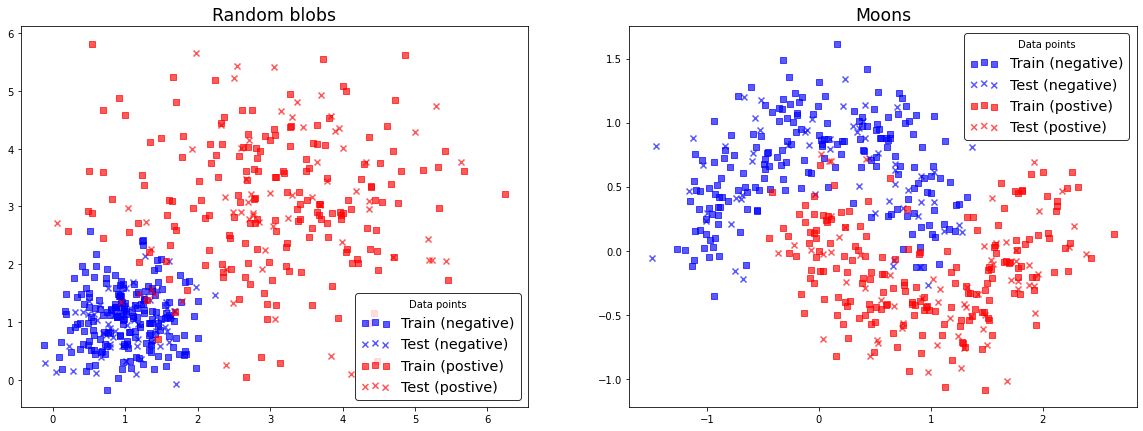

In [210]:
# Plot datasets
fig, axrr = plt.subplots(1, 2, figsize=(20, 7))

# Blobs
for l_str, l_num, col in [("negative", -1, "blue"), ("postive", 1, "red")]:    
    axrr[0].scatter(
        X_blobs_train[y_blobs_train==l_num, 0], X_blobs_train[y_blobs_train==l_num, 1],
        c=col, alpha=0.65, label="Train (%s)" % l_str, marker="s")
    
    axrr[0].scatter(
        X_blobs_test[y_blobs_test==l_num, 0], X_blobs_test[y_blobs_test==l_num, 1],
        c=col, alpha=0.65, label="Test (%s)" % l_str, marker="x")
        
# Blobs
for l_str, l_num, col in [("negative", -1, "blue"), ("postive", 1, "red")]:    
    axrr[1].scatter(
        X_moons_train[y_moons_train==l_num, 0], X_moons_train[y_moons_train==l_num, 1],
        c=col, alpha=0.65, label="Train (%s)" % l_str, marker="s")
    
    axrr[1].scatter(
        X_moons_test[y_moons_test==l_num, 0], X_moons_test[y_moons_test==l_num, 1],
        c=col, alpha=0.65, label="Test (%s)" % l_str, marker="x")


axrr[0].set_title("Random blobs", fontsize="xx-large")
axrr[0].legend(title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")

axrr[1].set_title("Moons", fontsize="xx-large")
axrr[1].legend(title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")

plt.show()

### A. Implement the hyper parameter optimization (3 point) <a id='task_3_a'></a>
Train (fit) your Parzen Window Classifier with Gaussian kernel on the training examples, i.e. `X_blobs_train` and `X_moons_train`. To find the optimal Gaussian bandwidth parameter $\sigma$ we search a grid of different parameter values and score each one using CV. 

<div class="alert alert-success">
    <b>Task:</b> Implement the missing code parts of the <code>hyper_parameter_search_using_cv</code> function. 
</div>

The function gets in a set of training examples and a grid of different parameters, e.g. $\sigma$'s, calculates an average validation set score for all of them using cross-validation. Subsequently, a model using all the training data ist used, to train a model with the best set of parameters. 

<div class="alert alert-warning">
    <b>Hints:</b>
    
- Make use of the Python tutorial (fetch on JupyterHub), if you want to see the pseudo-code of the parameter search. 
- Read the documentation of the sklearn [<code>KFold</code> function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold).
- You can calculate the performance score using <code>est.score(...)</code>. Read also: https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html#sklearn.base.ClassifierMixin.score
</div>


In [221]:
def hyper_parameter_search_using_cv(estimator, X, y, param_grid, n_cv_folds=5, 
                                    random_state=None):
    """
    Function calculating the estimator score for a grid of hyper parameters.

    :param estimator: object, subclass of RegressorMixin or ClassifierMixin and BaseEstimator
    :param X: array-like, shape=(n_samples, n_features), feature-matrix used for training
    :param y: array-like, shape=(n_samples,) or (n_samples, 1), label vector used for training
    :param param_grid: dictionary,
        keys: different parameter names
        values: grid-values for each parameter
    :param n_cv_folds: scalar, a KFold cross-validation is performed where the number of splits is equal the scalar.
    :param random_state: scalar, RandomState instance or None, optional, default=None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    :return: tuple = (
            best estimator,
            param grid as list and corresponding evaluation scores,
            score of best parameter
            best parameter
        )
    """
    # Get an iterator over all parameters
    param_grid_iter = ParameterGrid(param_grid)

    # Create cross-validation object
    cv = KFold(n_splits=n_cv_folds, random_state=random_state)
    
    # Store the valdidation set performance scores for all folds and parameters
    perf_scores = np.zeros((cv.get_n_splits(), len(param_grid_iter)))

    for fold, (train_set, val_set) in enumerate(cv.split(X, y)):
        # Separate training and validation set from X and y,
        #  i.e. X_train, X_val, y_train and y_val
        # YOUR CODE HERE
        X_train, X_val = X[train_set], X[val_set]
        y_train, y_val = y[train_set], y[val_set]

        for idx, param in enumerate(param_grid_iter):
            # Clone the estimator object to get an un-initialized object
            est = clone(estimator)

            # Set model parameters
            est.set_params(**param)

            # Fit the model using training set
            # YOUR CODE HERE
            est.fit(X_train, y_train)

            # Calculate the perf. score on validation set for current fold and parameter index
            # YOUR CODE HERE
            perf_scores[fold, idx] = est.score(X_val, y_val)
            
    # Find best performing hyper-parameter
    
    # Average the perf. scores for each parameter across each fold
    # YOUR CODE HERE
    avg_perf_scores = np.mean(perf_scores, axis=0)
    
    idx_best = np.argmax(avg_perf_scores)
    best_perf_score = avg_perf_scores[idx_best]
    best_param = param_grid_iter[idx_best]

    # Fit model using all data with the best parameters
    est = clone(estimator)
    est.set_params(**best_param)
    est.fit(X, y)

    return (est, {"params": list(param_grid_iter), "scores": avg_perf_scores}, 
            best_perf_score, best_param)


In [222]:
X, y = make_blobs(n_samples=100, centers=[[1, 1], [1.5, 1.5]], cluster_std=[0.2, 0.75], 
                  random_state=100)
y[y==0] = -1

_param_grid = {"sigma": [0.05, 0.1, 0.5, 1.]}
_est, _param_scores, _best_score, _best_param = hyper_parameter_search_using_cv(
    ParzenWindowClassifier(kernel="gaussian"), X, y, _param_grid)

np.testing.assert_equal(_param_scores["scores"].shape, (len(_param_grid["sigma"]),))
np.testing.assert_allclose(_param_scores["scores"], np.array([0.83, 0.91, 0.89, 0.83]))
np.testing.assert_equal(_best_param, {"sigma": 0.1})
np.testing.assert_allclose(_best_score, 0.91)
assert(isinstance(_est, ParzenWindowClassifier))


### B. Plot validation score for different hyper parameters <a id='task_3_b'></a>
With the hyper parameter optimization function at hand, we find the best $\sigma$ parameter for the two synthetic datasets and also inspect the average validation error for different values of $\sigma$.

First let us the parameter grid for the Gaussian kernel bandwidth parameter $\sigma$:

In [223]:
param_grid = {"sigma": [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}

Now we run the `hyper_parameter_search_using_cv` function for `X_blobs_train` and `X_blobs_test`:

In [224]:
est_blobs, scores_blobs, best_score_blobs, best_param_blobs = hyper_parameter_search_using_cv(
    ParzenWindowClassifier(kernel="gaussian"), X_blobs_train, y_blobs_train, param_grid,
    random_state=737)

print("[Blobs] Best average validation score", best_score_blobs)
print("[Blobs] Best parameter", best_param_blobs)

est_moons, scores_moons, best_score_moons, best_param_moons = hyper_parameter_search_using_cv(
    ParzenWindowClassifier(kernel="gaussian"), X_moons_train, y_moons_train, param_grid,
    random_state=747)

print("[Moons] Best average validation score", best_score_moons)
print("[Moons] Best parameter", best_param_moons)

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


[Blobs] Best average validation score 0.9706666666666667
[Blobs] Best parameter {'sigma': 1}
[Moons] Best average validation score 0.9359999999999999
[Moons] Best parameter {'sigma': 0.1}


Plot validation score for the different parameter values. 

<div class="alert alert-warning">
    <b>Hint:</b> Both curves should have a single maxima, if you did not change any random seeds, i.e. <code>random_state</code> values, or data generation parameters. Otherwise, it could be that multiple $\sigma$'s are equally good. However, overall it should be a function with single maxima (maybe a region).
</div>

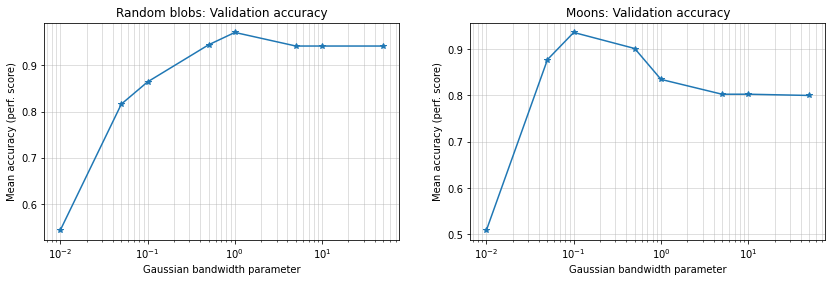

In [225]:
fig, axrr = plt.subplots(1, 2, figsize=(14, 4), sharex="row")

axrr[0].plot(param_grid["sigma"], scores_blobs["scores"], '*-')
axrr[0].set_xscale("log")
axrr[0].grid(True, which="both", ls="-", alpha=0.5)
axrr[0].set_title("Random blobs: Validation accuracy")
axrr[0].set_xlabel("Gaussian bandwidth parameter")
axrr[0].set_ylabel("Mean accuracy (perf. score)")

axrr[1].plot(param_grid["sigma"], scores_moons["scores"], '*-')
axrr[1].set_xscale("log")
axrr[1].grid(True, which="both", ls="-", alpha=0.5)
axrr[1].set_title("Moons: Validation accuracy")
axrr[1].set_xlabel("Gaussian bandwidth parameter")
axrr[1].set_ylabel("Mean accuracy (perf. score)")

plt.show()

The hyper-parameter optimization was done only using the training data. We now can apply the best model (with the optimal $\sigma$ parameter) to the training data. We should see a similar performance as for the validation set:

In [226]:
print("[Blobs] Score on test set", est_blobs.score(X_blobs_test, y_blobs_test))
print("[Moons] Score on test set", est_moons.score(X_moons_test, y_moons_test))

[Blobs] Score on test set 0.936
[Moons] Score on test set 0.912


## 4. Model visualization: Non-linear vs. Linear (**no points**)  <a id='task_4'></a>

<div class="alert alert-info">
    <b>Bonus task:</b>
    
Here we inspect the decision function and how it separates the two classes in the feature space. For that we will evaluate $g(\mathbf{x})$ for $\mathbf{x}$'s on a regular grid. 

1. Set up interval to plot decision function, e.g. min. and max. value of our synthetic datasets. 
2. Create grid-points $\mathbf{x}$ covering the intervall. 
3. Evaluate $z=g(\mathbf{x})$ for all points.
4. Plot the $z$'s for different points and color them according to their sign.
</div>

In [227]:
def get_gridpoints(X):
    """
    :param X: array-like, shape=(n_samples, d), datset feature matrix
    
    :return: array-like, shape=(n_grid_samples, d), feature vectors on a regular grid in the feature space
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    return xx, yy

def get_color_normalizer(Z, n_colors=256, n_point=10):
    bounds = np.append(np.linspace(np.min(Z), 0, n_point)[:-1], np.linspace(0, np.max(Z), n_point))  # do not add zero twice
    return colors.BoundaryNorm(boundaries=bounds, ncolors=n_colors)

### Decision Function for Gaussian Kernel (Model of previous tasks)

In [228]:
XX_blobs_grid, YY_blobs_grid = get_gridpoints(X_blobs)
Z_blobs_grid = est_blobs.decision_function(np.c_[XX_blobs_grid.ravel(), YY_blobs_grid.ravel()])
Z_blobs_grid = Z_blobs_grid.reshape(XX_blobs_grid.shape)

XX_moons_grid, YY_moons_grid = get_gridpoints(X_moons)
Z_moons_grid = est_moons.decision_function(np.c_[XX_moons_grid.ravel(), YY_moons_grid.ravel()])
Z_moons_grid = Z_moons_grid.reshape(XX_moons_grid.shape)

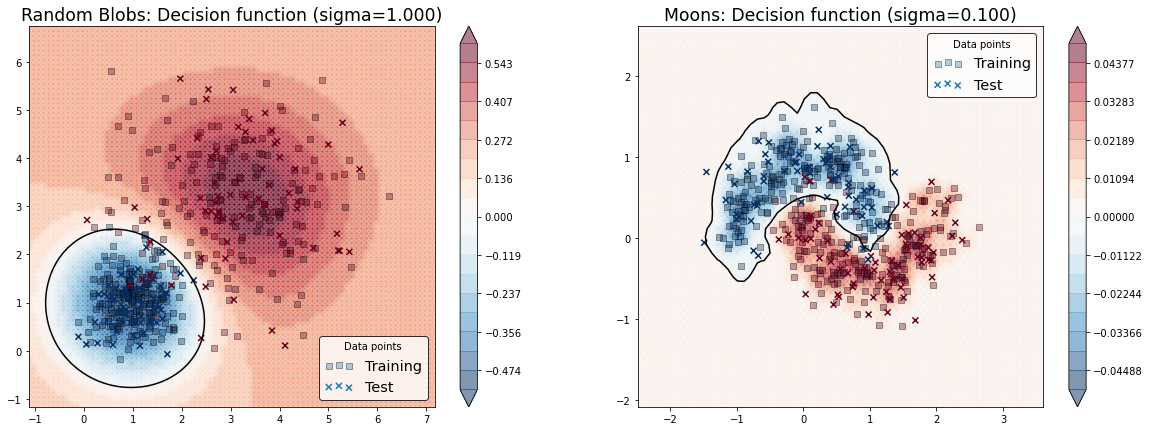

In [229]:
fig, axrr = plt.subplots(1, 2, figsize=(20, 7))

# plot contours, levels, ...
pcm = axrr[0].pcolormesh(XX_blobs_grid, YY_blobs_grid, Z_blobs_grid, alpha=0.5, shading="gouraud",
                   norm=get_color_normalizer(Z_blobs_grid))
fig.colorbar(pcm, ax=axrr[0], extend="both", orientation="vertical")
axrr[0].contour(XX_blobs_grid, YY_blobs_grid, Z_blobs_grid, colors=['k'], linestyles=['-'], levels=[0])

# plot points
axrr[0].scatter(X_blobs_train[:, 0], X_blobs_train[:, 1], c=y_blobs_train, marker="s", edgecolors="k", alpha=0.35)
axrr[0].scatter(X_blobs_test[:, 0], X_blobs_test[:, 1], c=y_blobs_test, marker="x", edgecolors="k")

# plot labels, titles, ...
axrr[0].legend(["Training", "Test"], title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")
axrr[0].set_title("Random Blobs: Decision function (sigma=%.3f)" % best_param_blobs["sigma"],
                 fontsize="xx-large")

pcm = axrr[1].pcolormesh(XX_moons_grid, YY_moons_grid, Z_moons_grid, alpha=0.5, shading="gouraud",
                   norm=get_color_normalizer(Z_moons_grid))
fig.colorbar(pcm, ax=axrr[1], extend="both", orientation="vertical")
axrr[1].scatter(X_moons_train[:, 0], X_moons_train[:, 1], c=y_moons_train, marker="s", edgecolors="k", alpha=0.35)
axrr[1].scatter(X_moons_test[:, 0], X_moons_test[:, 1], c=y_moons_test, edgecolors="k", marker="x")
axrr[1].legend(["Training", "Test"], title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")
axrr[1].set_title("Moons: Decision function (sigma=%.3f)" % best_param_moons["sigma"],
                 fontsize="xx-large")
axrr[1].contour(XX_moons_grid, YY_moons_grid, Z_moons_grid, colors=['k'], linestyles=['-'], levels=[0])

plt.show()

### Decision Function for Linear Kernel
We have seen that the Gaussian kernel leads to a non-linear decision boundary, i.e. $g(\mathbf{x})=0$ (black line in plots). Now we take a look on the linear Parzen Window Classifier, buy using a linear kernel.

In [230]:
est_blobs = ParzenWindowClassifier(kernel="linear")
est_blobs.fit(X_blobs_train, y_blobs_train)

est_moons = ParzenWindowClassifier(kernel="linear")
est_moons.fit(X_moons_train, y_moons_train)

In [231]:
XX_blobs_grid, YY_blobs_grid = get_gridpoints(X_blobs)
Z_blobs_grid = est_blobs.decision_function(np.c_[XX_blobs_grid.ravel(), YY_blobs_grid.ravel()])
Z_blobs_grid = Z_blobs_grid.reshape(XX_blobs_grid.shape)

XX_moons_grid, YY_moons_grid = get_gridpoints(X_moons)
Z_moons_grid = est_moons.decision_function(np.c_[XX_moons_grid.ravel(), YY_moons_grid.ravel()])
Z_moons_grid = Z_moons_grid.reshape(XX_moons_grid.shape)

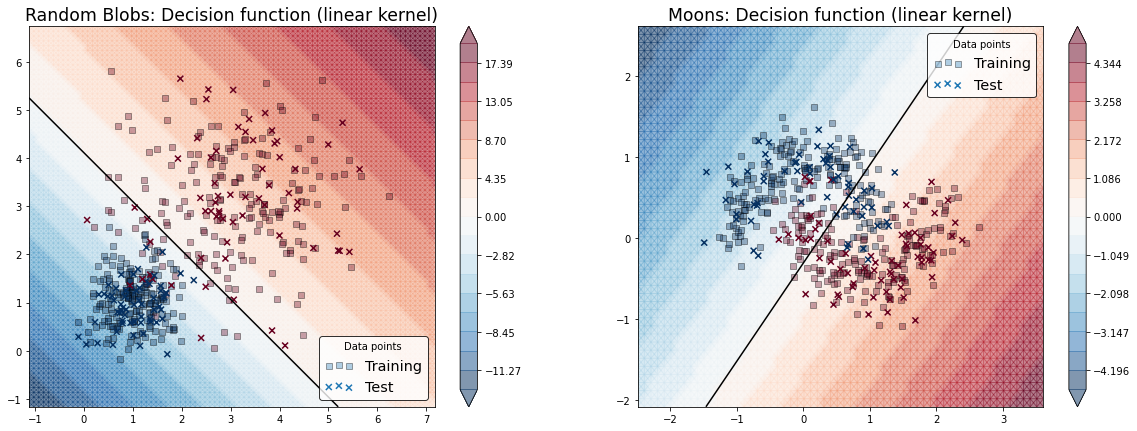

In [232]:
fig, axrr = plt.subplots(1, 2, figsize=(20, 7))

# plot contours, levels, ...
pcm = axrr[0].pcolormesh(XX_blobs_grid, YY_blobs_grid, Z_blobs_grid, alpha=0.5, shading="gouraud",
                   norm=get_color_normalizer(Z_blobs_grid))
fig.colorbar(pcm, ax=axrr[0], extend="both", orientation="vertical")
axrr[0].contour(XX_blobs_grid, YY_blobs_grid, Z_blobs_grid, colors=['k'], linestyles=['-'], levels=[0])

# plot points
axrr[0].scatter(X_blobs_train[:, 0], X_blobs_train[:, 1], c=y_blobs_train, marker="s", edgecolors="k", alpha=0.35)
axrr[0].scatter(X_blobs_test[:, 0], X_blobs_test[:, 1], c=y_blobs_test, edgecolors="k", marker="x")

# plot labels, titles, ...
axrr[0].legend(["Training", "Test"], title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")
axrr[0].set_title("Random Blobs: Decision function (linear kernel)", fontsize="xx-large")

pcm = axrr[1].pcolormesh(XX_moons_grid, YY_moons_grid, Z_moons_grid, alpha=0.5, shading="gouraud",
                   norm=get_color_normalizer(Z_moons_grid))
fig.colorbar(pcm, ax=axrr[1], extend="both", orientation="vertical")
axrr[1].scatter(X_moons_train[:, 0], X_moons_train[:, 1], c=y_moons_train, marker="s", edgecolors="k", alpha=0.35)
axrr[1].scatter(X_moons_test[:, 0], X_moons_test[:, 1], c=y_moons_test, edgecolors="k", marker="x")
axrr[1].legend(["Training", "Test"], title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")
axrr[1].set_title("Moons: Decision function (linear kernel)", fontsize="xx-large")
axrr[1].contour(XX_moons_grid, YY_moons_grid, Z_moons_grid, colors=['k'], linestyles=['-'], levels=[0])

plt.show()